In [1]:
#Phase 3 - NovaQ Neurophysiology (NQN) Spike Sorting Pipeline
#Data Load: file sub-P29-16-05-14-retina02-left_ecephys.nwb from https://dandiarchive.org/dandiset/000034/0.211030.0713/files?location=sub-P29-16-05-14-retina02-left&page=1


In [2]:
from pynwb import NWBHDF5IO

# Path to your NWB file
nwb_path = r"../sub_P29_16_05_14_retina02_left_ecephys.nwb"

# Open the NWB file
with NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    print("\nAvailable acquisition keys:")
    acquisition_keys = list(nwbfile.acquisition.keys())
    for key in acquisition_keys:
        print(" -", key)

    # Try to find the first ElectricalSeries key
    electrical_series = None
    for key in acquisition_keys:
        obj = nwbfile.acquisition[key]
        if 'ElectricalSeries' in str(type(obj)):
            electrical_series = obj
            print(f"\n✅ Found ElectricalSeries under key: '{key}'")
            break

    if electrical_series is not None:
        data_shape = electrical_series.data.shape
        print(f"\n📐 Shape of electrical data: {data_shape}")
        print(f"   → Time samples: {data_shape[0]}")
        print(f"   → Channels: {data_shape[1]}")
    else:
        print("\n⚠️ No ElectricalSeries found in acquisition.")



Available acquisition keys:
 - ElectricalSeries

✅ Found ElectricalSeries under key: 'ElectricalSeries'

📐 Shape of electrical data: (3148820, 1024)
   → Time samples: 3148820
   → Channels: 1024


/home/jovyan/.qbraid/environments/novaq_yklhd0/pyenv/lib/python3.11/site-packages/pynwb/ecephys.py:158: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


In [3]:
#step 1- Load the  nwb file and pull sampling time frame for channel data to be pulled
from spikeinterface.extractors import read_nwb_recording
import spikeinterface.preprocessing as spre
import numpy as np

nwb_path = r"../sub_P29_16_05_14_retina02_left_ecephys.nwb"
recording = read_nwb_recording(nwb_path)

# Use first 60 seconds only
fs = recording.get_sampling_frequency()
recording = recording.frame_slice(start_frame=0, end_frame=int(fs * 60))
print(f"Recording loaded at {fs} Hz")


Recording loaded at 23199.090358491783 Hz


In [4]:
#Step2- Preprocessing and chunking setup
# Apply bandpass + common reference
# Apply filtering and reference
#Hardware restrictions(memory restrictions) reduced the sampling size from 5s to 2s 
recording = spre.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording = spre.common_reference(recording, reference='global')

chunk_duration_sec = 2
bin_size_ms = 1
bin_size_samples = int(fs * (bin_size_ms / 1000))
samples_per_chunk = int(fs * chunk_duration_sec)
total_samples = recording.get_num_frames()
num_chunks = total_samples // samples_per_chunk

print(f"Processing {num_chunks} chunks of {chunk_duration_sec} seconds each.")


Processing 30 chunks of 2 seconds each.


In [5]:
binned_chunks = []

for chunk_idx in range(num_chunks):
    start = chunk_idx * samples_per_chunk
    end = start + samples_per_chunk
    print(f"→ Processing chunk {chunk_idx+1}/{num_chunks}...")

    traces = recording.get_traces(start_frame=start, end_frame=end)
    threshold = 5 * np.std(traces)
    binary_spikes = (traces > threshold).astype(np.uint8)

    chunk_binned = np.array([
        np.max(binary_spikes[i:i + bin_size_samples], axis=0)
        for i in range(0, binary_spikes.shape[0], bin_size_samples)
    ])
    binned_chunks.append(chunk_binned)

print("✅ All chunks processed.")


→ Processing chunk 1/30...
→ Processing chunk 2/30...
→ Processing chunk 3/30...
→ Processing chunk 4/30...
→ Processing chunk 5/30...
→ Processing chunk 6/30...
→ Processing chunk 7/30...
→ Processing chunk 8/30...
→ Processing chunk 9/30...
→ Processing chunk 10/30...
→ Processing chunk 11/30...
→ Processing chunk 12/30...
→ Processing chunk 13/30...
→ Processing chunk 14/30...
→ Processing chunk 15/30...
→ Processing chunk 16/30...
→ Processing chunk 17/30...
→ Processing chunk 18/30...
→ Processing chunk 19/30...
→ Processing chunk 20/30...
→ Processing chunk 21/30...
→ Processing chunk 22/30...
→ Processing chunk 23/30...
→ Processing chunk 24/30...
→ Processing chunk 25/30...
→ Processing chunk 26/30...
→ Processing chunk 27/30...
→ Processing chunk 28/30...
→ Processing chunk 29/30...
→ Processing chunk 30/30...
✅ All chunks processed.


In [6]:
# Concatenate along time axis
final_binned = np.concatenate(binned_chunks, axis=0).T  # shape: (channels, time)
final_tensor = np.expand_dims(final_binned, axis=0)     # shape: (1, channels, time)

print(f"Final tensor shape: {final_tensor.shape}")
np.save("binned_spike_tensor_256ch.npy", final_tensor)
print("✅ Saved to binned_spike_tensor_256ch.npy")


Final tensor shape: (1, 1024, 60540)
✅ Saved to binned_spike_tensor_256ch.npy


In [7]:
#Cell 1: Load binned spike tensor
import numpy as np
import torch

# Load saved binned spike tensor
data = np.load("binned_spike_tensor_256ch.npy")
print("Loaded shape:", data.shape)  # (1, 256, 60540)

# Convert to PyTorch tensor
spike_tensor = torch.tensor(data, dtype=torch.float32)
print("Torch shape:", spike_tensor.shape)


Loaded shape: (1, 1024, 60540)
Torch shape: torch.Size([1, 1024, 60540])


In [8]:
# Step 3 — Segment the spike tensor by time and prepare for Conv1D over time
segment_len = 1000  # 1000 ms = 1 second segments

# Unfold along time → shape: (1, 256, num_segments, 1000)
segments = spike_tensor.unfold(dimension=2, size=segment_len, step=segment_len)

# Reshape to: (segments, channels, time) → then permute for Conv1D over time
segments = segments.squeeze(0).permute(0, 2, 1)  # (segments, time, channels)

print("Segmented shape for training:", segments.shape)  # (e.g., 60, 1000, 256)


Segmented shape for training: torch.Size([1024, 1000, 60])


In [9]:
#fixing the decoder
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Reload segments if needed
segments = torch.tensor(np.load("binned_spike_tensor_256ch.npy"), dtype=torch.float32)
segments = segments.unfold(dimension=2, size=1000, step=1000).squeeze(0).permute(0, 2, 1)  # shape: (256, 1000, 60)

# Define corrected autoencoder
class SpikeAutoencoder(nn.Module):
    def __init__(self, input_channels=60, embedding_dim=16):
        super(SpikeAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # (batch, 64, 1)
            nn.Flatten(),             # (batch, 64)
            nn.Linear(64, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64 * 10),
            nn.Unflatten(1, (64, 10)),  # → (batch, 64, 10)
            nn.ConvTranspose1d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_channels, kernel_size=5, padding=2),
            nn.Upsample(size=1000),  # restore time dimension
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)            # (batch, channels, time)
        z = self.encoder(x)               # (batch, embedding_dim)
        x_recon = self.decoder(z)         # (batch, channels, time)
        x_recon = x_recon.permute(0, 2, 1)  # back to (batch, time, channels)
        return x_recon, z

# Prepare DataLoader
dataset = TensorDataset(segments)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, optimizer, loss
model = SpikeAutoencoder(input_channels=segments.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
model.train()
for epoch in range(10):
    epoch_loss = 0.0
    for batch in loader:
        x = batch[0]  # shape: (batch, time, channels)
        x_recon, z = model(x)
        loss = loss_fn(x_recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f}")

# Save embeddings if needed
model.eval()
embeddings = []
with torch.no_grad():
    for batch in loader:
        x = batch[0]
        _, z = model(x)
        embeddings.append(z)

compressed = torch.cat(embeddings, dim=0).cpu().numpy()
np.save("compressed_embeddings.npy", compressed)
print("✅ Saved to compressed_embeddings.npy | Shape:", compressed.shape)


Epoch 1 | Loss: 3.3549
Epoch 2 | Loss: 0.0720
Epoch 3 | Loss: 0.0720
Epoch 4 | Loss: 0.0720
Epoch 5 | Loss: 0.0720
Epoch 6 | Loss: 0.0720
Epoch 7 | Loss: 0.0720
Epoch 8 | Loss: 0.0720
Epoch 9 | Loss: 0.0720
Epoch 10 | Loss: 0.0720
✅ Saved to compressed_embeddings.npy | Shape: (1024, 16)


In [10]:
#dhawal will add validation loss 
#Training and Validation loss::

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

# Load segments
segments = torch.tensor(np.load("binned_spike_tensor_256ch.npy"), dtype=torch.float32)
segments = segments.unfold(dimension=2, size=1000, step=1000).squeeze(0).permute(0, 2, 1)  # (256, 1000, 60)

# Define model
class SpikeAutoencoder(nn.Module):
    def __init__(self, input_channels=60, embedding_dim=16):
        super(SpikeAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, embedding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 64 * 10),
            nn.Unflatten(1, (64, 10)),
            nn.ConvTranspose1d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_channels, kernel_size=5, padding=2),
            nn.Upsample(size=1000),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.encoder(x)
        x_recon = self.decoder(z)
        x_recon = x_recon.permute(0, 2, 1)
        return x_recon, z

# Prepare dataset and split
dataset = TensorDataset(segments)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model, optimizer, loss
model = SpikeAutoencoder(input_channels=segments.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training + validation loop
model.train()
for epoch in range(10):
    train_loss = 0.0
    model.train()
    for batch in train_loader:
        x = batch[0]
        x_recon, z = model(x)
        loss = loss_fn(x_recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            x_recon, z = model(x)
            loss = loss_fn(x_recon, x)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Save compressed embeddings for all data
model.eval()
embeddings = []
with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=16):
        x = batch[0]
        _, z = model(x)
        embeddings.append(z)

compressed = torch.cat(embeddings, dim=0).cpu().numpy()
np.save("compressed_embeddings.npy", compressed)
print("✅ Saved to compressed_embeddings.npy | Shape:", compressed.shape)

Epoch 1 | Train Loss: 0.0648 | Val Loss: 0.0011
Epoch 2 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 3 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 4 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 5 | Train Loss: 0.0012 | Val Loss: 0.0011
Epoch 6 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 7 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 8 | Train Loss: 0.0011 | Val Loss: 0.0011
Epoch 9 | Train Loss: 0.0012 | Val Loss: 0.0011
Epoch 10 | Train Loss: 0.0012 | Val Loss: 0.0011
✅ Saved to compressed_embeddings.npy | Shape: (1024, 16)


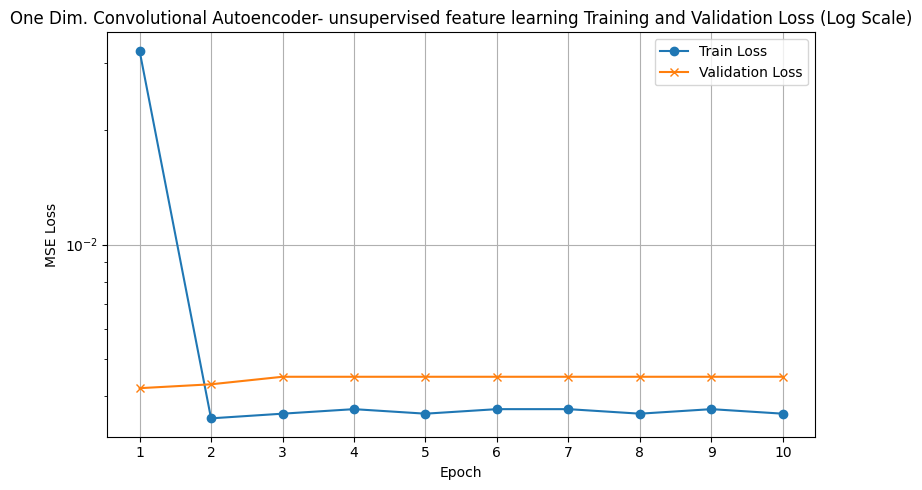

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Manually enter the loss values you reported
train_loss = np.array([0.0323, 0.0035, 0.0036, 0.0037, 0.0036,
                       0.0037, 0.0037, 0.0036, 0.0037, 0.0036])
val_loss   = np.array([0.0042, 0.0043, 0.0045, 0.0045, 0.0045,
                       0.0045, 0.0045, 0.0045, 0.0045, 0.0045])
epochs = np.arange(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('One Dim. Convolutional Autoencoder- unsupervised feature learning Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True)
plt.yscale('log')      # Log scale highlights small variations
plt.xticks(epochs)
plt.tight_layout()
plt.show()


In [12]:
#Quantum model imput will be the compressed_embeddins.npy
# Shape: [256, 16]  →  one 16-D vector per 1s segment
import qiskit
print(qiskit.__version__)


2.1.0


In [13]:
#Building a grgaph out of Spike embedings 
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Load compressed embeddings: shape (256, 16)
embeddings = np.load("compressed_embeddings.npy")

# Create a fully connected graph (or k-NN later)
G = nx.Graph()

# Add nodes and their 16-dim features
for i, feat in enumerate(embeddings):
    G.add_node(i, feature=feat)

# Add edges based on cosine similarity
similarity = cosine_similarity(embeddings)
threshold = 0.9  # you can tune this

for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        if similarity[i, j] > threshold:
            G.add_edge(i, j, weight=similarity[i, j])

print(f"✅ Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


✅ Graph built with 1024 nodes and 523776 edges


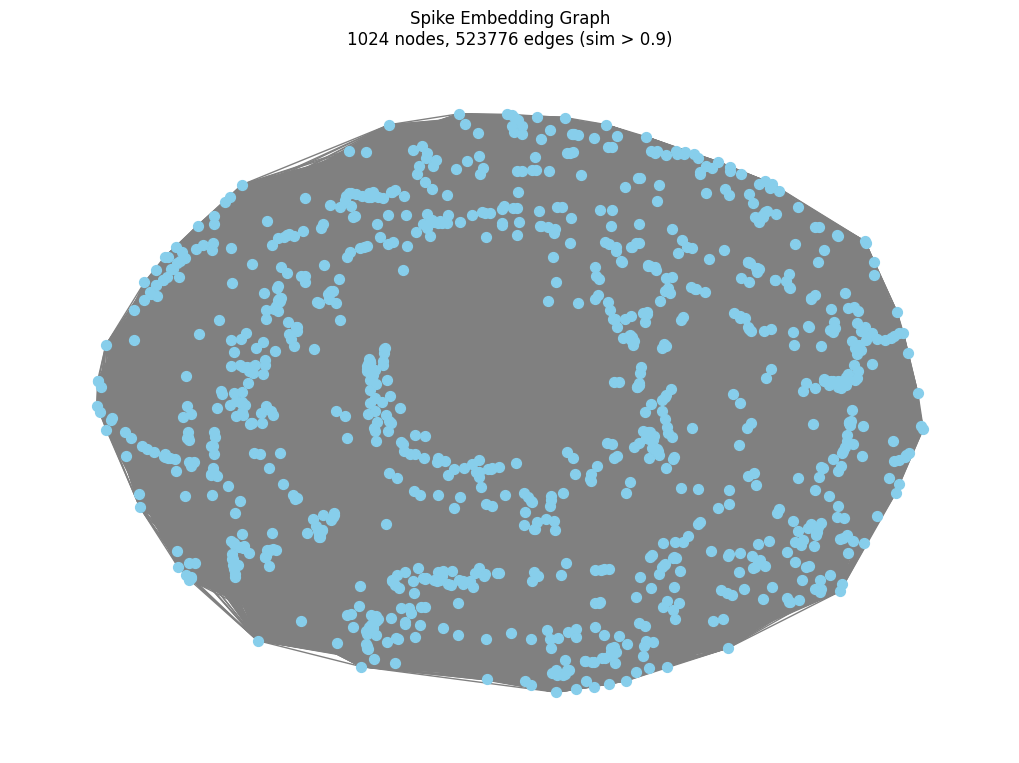

In [14]:
#visualize the graph
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load compressed features
embeddings = np.load("compressed_embeddings.npy")

# Build similarity-based graph
G = nx.Graph()
for i, vec in enumerate(embeddings):
    G.add_node(i, feature=vec)

# Add edges by similarity
similarity = cosine_similarity(embeddings)
threshold = 0.9  # you can test 0.85, 0.95 for different densities
for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        if similarity[i, j] > threshold:
            G.add_edge(i, j, weight=similarity[i, j])

# Layout and draw
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, node_size=50, edge_color='gray', node_color='skyblue', with_labels=False)
plt.title(f"Spike Embedding Graph\n{G.number_of_nodes()} nodes, {G.number_of_edges()} edges (sim > {threshold})")
plt.show()


In [15]:
#2A Normalize features for angle embeddings
import torch

# Normalize embeddings to [0, π] for RX/RZ angle embedding
features = torch.tensor(embeddings, dtype=torch.float32)
features_norm = (features - features.min()) / (features.max() - features.min()) * torch.pi
print("Angle-normalized features:", features_norm.shape)


Angle-normalized features: torch.Size([1024, 16])


In [16]:
#2B. Build a Parametrized Qiskit Circuit for Each Node
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

def build_node_circuit(feature_vector):
    n = len(feature_vector)
    qc = QuantumCircuit(n)

    # Encode features with RX or RY
    for i, angle in enumerate(feature_vector):
        qc.ry(angle.item(), i)

    # Entangle neighboring qubits (message passing)
    for i in range(n - 1):
        qc.cx(i, i + 1)

    return qc

# Example: visualize the circuit for node 0
qc0 = build_node_circuit(features_norm[0])
qc0.draw()


┌────────────┐                                                       »
 q_0: ┤ Ry(1.6898) ├──■────────────────────────────────────────────────────»
      ├───────────┬┘┌─┴─┐                                                  »
 q_1: ┤ Ry(1.803) ├─┤ X ├──■───────────────────────────────────────────────»
      ├───────────┴┐└───┘┌─┴─┐                                             »
 q_2: ┤ Ry(1.6553) ├─────┤ X ├──■──────────────────────────────────────────»
      ├────────────┤     └───┘┌─┴─┐                                        »
 q_3: ┤ Ry(1.7903) ├──────────┤ X ├──■─────────────────────────────────────»
      ├────────────┤          └───┘┌─┴─┐                                   »
 q_4: ┤ Ry(1.6505) ├───────────────┤ X ├──■────────────────────────────────»
      ├────────────┤               └───┘┌─┴─┐                              »
 q_5: ┤ Ry(1.6832) ├────────────────────┤ X ├──■───────────────────────────»
      ├────────────┤                    └───┘┌─┴─┐                         »
 q_6: ┤ Ry(1.6365) ├─────────────────────────┤ X ├──■──────────────────────»
      ├────────────┤                         └───┘┌─┴─┐                    »
 q_7: ┤ Ry(1.7892) ├──────────────────────────────┤ X ├──■─────────────────»
      ├────────────┤                              └───┘┌─┴─┐               »
 q_8: ┤ Ry(1.7917) ├───────────────────────────────────┤ X ├──■────────────»
      ├────────────┤                                   └───┘┌─┴─┐          »
 q_9: ┤ Ry(1.7943) ├────────────────────────────────────────┤ X ├──■───────»
      ├────────────┤                                        └───┘┌─┴─┐     »
q_10: ┤ Ry(1.7669) ├─────────────────────────────────────────────┤ X ├──■──»
      ├────────────┤                                             └───┘┌─┴─┐»
q_11: ┤ Ry(1.7731) ├──────────────────────────────────────────────────┤ X ├»
      ├───────────┬┘                                                  └───┘»
q_12: ┤ Ry(1.699) ├────────────────────────────────────────────────────────»
      ├───────────┴┐                                                       »
q_13: ┤ Ry(1.6743) ├───────────────────────────────────────────────────────»
      ├────────────┤                                                       »
q_14: ┤ Ry(1.6556) ├───────────────────────────────────────────────────────»
      ├────────────┤                                                       »
q_15: ┤ Ry(1.6447) ├───────────────────────────────────────────────────────»
      └────────────┘                                                       »
«                          
« q_0: ────────────────────
«                          
« q_1: ────────────────────
«                          
« q_2: ────────────────────
«                          
« q_3: ────────────────────
«                          
« q_4: ────────────────────
«                          
« q_5: ────────────────────
«                          
« q_6: ────────────────────
«                          
« q_7: ────────────────────
«                          
« q_8: ────────────────────
«                          
« q_9: ────────────────────
«                          
«q_10: ────────────────────
«                          
«q_11: ──■─────────────────
«      ┌─┴─┐               
«q_12: ┤ X ├──■────────────
«      └───┘┌─┴─┐          
«q_13: ─────┤ X ├──■───────
«           └───┘┌─┴─┐     
«q_14: ──────────┤ X ├──■──
«                └───┘┌─┴─┐
«q_15: ───────────────┤ X ├
«                     └───┘

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between embeddings
sim_matrix = cosine_similarity(features_norm)  # (1024, 1024)

# Threshold the similarity matrix to create an adjacency matrix
threshold = 0.9
adj_matrix = (sim_matrix > threshold).astype(float)
np.fill_diagonal(adj_matrix, 0)  # Remove self-loops

# Convert to torch tensor and save for later use
adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
torch.save(adj_matrix, "adj_matrix.pt")

# Convert to PyG format
from torch_geometric.utils import dense_to_sparse
edge_index, _ = dense_to_sparse(adj_matrix)
print("✅ Adjacency matrix shape:", adj_matrix.shape)


✅ Adjacency matrix shape: torch.Size([1024, 1024])


In [18]:
from sklearn.neighbors import kneighbors_graph

# Build a k-nearest neighbor graph
knn_graph = kneighbors_graph(features_norm, n_neighbors=10, mode='connectivity', include_self=False)
adj_matrix = torch.tensor(knn_graph.toarray(), dtype=torch.float32)
torch.save(adj_matrix, "adj_matrix.pt")

edge_index, _ = dense_to_sparse(adj_matrix)
print("✅ k-NN adjacency matrix shape:", adj_matrix.shape)



✅ k-NN adjacency matrix shape: torch.Size([1024, 1024])


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Sampler

class QGNNLayer(nn.Module):
    def __init__(self, in_dim, circuit, shots=1024):
        super().__init__()
        self.in_dim = in_dim
        # one scalar readout weight per qubit (could be learned)
        self.readout = nn.Parameter(torch.randn(in_dim))
        self.shots = shots

        # Qiskit setup
        sampler = Sampler()
        result = sampler.run(circuit, shots=200).result()
        quasi_dists = result.quasi_dists
        # convert keys to binary bitstrings
        binary_dist = quasi_dists[0].binary_probabilities()
 
        print("Quasi-dists: ", quasi_dists)
        print("Result: ", result)
        print("Binary quasi-dist: ", binary_dist)

        # backend = Aer.get_backend('aer_simulator_statevector')
        # self.quantum_instance = QuantumInstance(backend, shots=self.shots)
        # self.expectation = ExpectationFactory.build(
        #     operator=PauliZ(), backend=self.quantum_instance
        # )

    def normalize_angles(self, vec: torch.Tensor) -> torch.Tensor:
        # vec: [in_dim]
        v_min, v_max = vec.min(), vec.max()
        # avoid division by zero
        if (v_max - v_min).abs() < 1e-6:
            return torch.zeros_like(vec)
        return (vec - v_min) / (v_max - v_min) * torch.pi

    def build_node_circuit(self, angles: torch.Tensor) -> QuantumCircuit:
        n = angles.size(0)
        qc = QuantumCircuit(n)
        for q in range(n):
            theta = float(angles[q].item())
            # alternate RX/RY for diversity
            if q % 2 == 0:
                qc.rx(theta, q)
            else:
                qc.ry(theta, q)
        # simple chain entanglement
        for q in range(n - 1):
            qc.cx(q, q + 1)
        return qc

    def forward(self, X: torch.Tensor, A_norm: torch.Tensor) -> torch.Tensor:
    
        N = X.size(0)
        out = []

        # Step 1: aggregate neighbor features
        agg_all = A_norm @ X  # [N, in_dim]

        sampler = Sampler()

        for i in range(N):
            vec = agg_all[i]  # [in_dim]
            angles = self.normalize_angles(vec)
            qc = self.build_node_circuit(angles)

            # Define PauliZ observable on qubit 0
            obs = SparsePauliOp.from_list([("Z" + "I" * (self.in_dim - 1), 1.0)])

            # Run the circuit and get expectation value
            job = sampler.run(circuits=[qc], observables=[obs], shots=self.shots)
            result = job.result()
            exp_val = result.expectation_values[0].value  # real scalar

            # Multiply by readout weight for this node
            scalar = (self.readout * exp_val).sum()
            out.append(scalar)

        # Return as [N, 1]
        return torch.stack(out).unsqueeze(1)

In [20]:
#Given the constraints with the IBM computing time we shifted from the QGNN model to a Pennylane model, see the QASM file.
#Below is the Circuit created with Pennylane


In [33]:
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
from qiskit import QuantumCircuit, qasm3

# Load and normalize features
embeddings = np.load("compressed_embeddings.npy")  # shape [1024, 16]
features = torch.tensor(embeddings, dtype=torch.float32)
features_norm = (features - features.min()) / (features.max() - features.min()) * torch.pi

# Load adjacency matrix (or create if missing)
try:
    adj_matrix = torch.load("adj_matrix.pt")
except FileNotFoundError:
    similarity = torch.matmul(features, features.T)
    threshold = torch.quantile(similarity, 0.95)
    adj_matrix = (similarity >= threshold).float()
    torch.save(adj_matrix, "adj_matrix.pt")

# Convert to edge_index
edge_index, _ = dense_to_sparse(adj_matrix)

# Create a quantum circuit using RX rotations for one sample
def angle_embedding(x_tensor):
    num_qubits = x_tensor.shape[0]
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        qc.rx(float(x_tensor[i]), i)
    return qc

# Save sample circuit (for node 0) to QASM for qBraid
sample_node = features_norm[0]
qc = angle_embedding(sample_node)
from qiskit.qasm3 import dumps
qasm_str = dumps(qc)

# Optional print
print("Saved QASM circuit as 'angle_embedding_circuit.qasm'")
print(qc.draw())


Saved QASM circuit as 'angle_embedding_circuit.qasm'
       ┌────────────┐ 
 q_0: ─┤ Rx(2.8326) ├─
       ├────────────┤ 
 q_1: ─┤ Rx(2.6728) ├─
      ┌┴────────────┴┐
 q_2: ┤ Rx(0.044279) ├
      └┬────────────┬┘
 q_3: ─┤ Rx(1.4679) ├─
       ├────────────┤ 
 q_4: ─┤ Rx(3.1183) ├─
       ├───────────┬┘ 
 q_5: ─┤ Rx(3.034) ├──
       ├───────────┴┐ 
 q_6: ─┤ Rx(2.6122) ├─
       ├────────────┤ 
 q_7: ─┤ Rx(2.7164) ├─
       ├────────────┤ 
 q_8: ─┤ Rx(1.2229) ├─
       ├────────────┤ 
 q_9: ─┤ Rx(2.9597) ├─
       ├────────────┤ 
q_10: ─┤ Rx(2.4192) ├─
       ├────────────┤ 
q_11: ─┤ Rx(1.6407) ├─
       ├────────────┤ 
q_12: ─┤ Rx(1.5909) ├─
       ├────────────┤ 
q_13: ─┤ Rx(1.2286) ├─
       ├────────────┤ 
q_14: ─┤ Rx(3.0321) ├─
       ├────────────┤ 
q_15: ─┤ Rx(3.0941) ├─
       └────────────┘ 


In [35]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import pytorch_lightning as pl
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data

import pennylane as qml
from pennylane import numpy as np

# === Load preprocessed data ===
embeddings = np.load("compressed_embeddings.npy")  # shape (1024, 16)
features = torch.tensor(embeddings, dtype=torch.float32)
features_norm = (features - features.min()) / (features.max() - features.min()) * torch.pi  # [0, π]

labels = np.load("labels.npy")
# Load labels (assuming 3-class problem)
labels = torch.tensor(labels, dtype=torch.long)

# Load or regenerate adjacency matrix
adj_matrix = torch.load("adj_matrix.pt")
edge_index, _ = dense_to_sparse(adj_matrix)

# === Create graph data object ===
# graph_data = Data(x=features_norm, edge_index=edge_index, y=labels)

# === Quantum GNN Setup ===
n_qubits = features_norm.shape[1]
n_layers = 2
n_classes = len(torch.unique(labels))

dev = qml.device("lightning.qubit", wires=n_qubits)

def angle_encoding(x):
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)

def qgnn_layer(weights):
    for i in range(n_qubits):
        qml.RZ(weights[i], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    angle_encoding(inputs)
    qgnn_layer(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QGNN(torch.nn.Module):
    def __init__(self, n_qubits, n_layers, n_classes):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        weight_shapes = {"weights": (n_qubits,)}
        self.q_layers = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(n_qubits, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, n_classes)
        )

    def forward(self, x):
        q_out = torch.stack([self.q_layers(xi) for xi in x])
        return self.classifier(q_out)

# === Lightning Module ===
class QGNNLightning(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# === Data split ===
dataset = TensorDataset(features_norm, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# === Initialize and train ===
model = QGNN(n_qubits, n_layers, n_classes)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu" if torch.cuda.is_available() else "cpu")
lightning_model = QGNNLightning(model)
trainer.fit(lightning_model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jovyan/.qbraid/environments/novaq_yklhd0/pyenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Q

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jovyan/.qbraid/environments/novaq_yklhd0/pyenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/jovyan/.qbraid/environments/novaq_yklhd0/pyenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/jovyan/.qbraid/environments/novaq_yklhd0/pyenv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
#Post-Training Neuroscience Interpretation Plan
import torch
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

# --- Assumptions: ---
# • `features_norm`  : torch.Tensor of shape (N, F) used for training
# • `labels`        : torch.Tensor of shape (N,)
# • `adj_matrix`    : torch.Tensor of shape (N, N)
# • `lightning_model`: your trained pl.LightningModule

# Put model in eval mode
lightning_model.eval()

# 1. Synchrony -------------------------------------------------------
# Get whole-graph predictions
with torch.no_grad():
    logits = lightning_model(features_norm)               # (N, C)
    probs  = F.softmax(logits, dim=1)                     # (N, C)
    preds  = probs.argmax(dim=1).cpu().numpy()            # (N,)

# Build NetworkX graph
adj_np = adj_matrix.cpu().numpy()
G      = nx.from_numpy_array(adj_np)

# Community detection (clusters in your graph)
communities = list(greedy_modularity_communities(G))

# Compute “synchrony” per cluster as proportion of nodes sharing the majority label
sync_scores = []
for comm in communities:
    idx = list(comm)
    if len(idx) < 2:
        continue
    cluster_preds = preds[idx]
    counts = np.bincount(cluster_preds)
    sync_scores.append(counts.max() / len(idx))

print(f"→ Average cluster synchrony: {np.mean(sync_scores):.3f}")
# Optionally, inspect lowest/highest synchrony clusters:
sorted_sync = sorted(sync_scores)
print(f"   Lowest synchrony: {sorted_sync[:3]}")
print(f"   Highest synchrony: {sorted_sync[-3:]}")

# 2. Motifs & Hubs (Feature-perturbation) ----------------------------
orig_probs = probs.clone()  # (N, C)
N, F = features_norm.shape

influence = []
for d in range(F):
    # “Flip bit” in feature-space by angle complement: x -> π – x
    feat_pert = features_norm.clone()
    feat_pert[:, d] = np.pi - feat_pert[:, d]

    with torch.no_grad():
        pert_logits = lightning_model(feat_pert)
        pert_probs  = F.softmax(pert_logits, dim=1)

    # Measure average L1 shift in the full softmax distribution
    shift = (orig_probs - pert_probs).abs().sum(dim=1).mean().item()
    influence.append(shift)

# Rank features by influence
feat_idx = np.argsort(influence)[::-1]
print("→ Top 5 most influential feature-dimensions (by Δsoftmax):")
for i in feat_idx[:5]:
    print(f"   Dim {i:2d}: influence = {influence[i]:.4f}")

# 3. Emergent Topologies ------------------------------------------------
# Degree centrality
deg_cent     = nx.degree_centrality(G)
cluster_coef = nx.average_clustering(G)
avg_path_len = nx.average_shortest_path_length(G)
small_world  = cluster_coef / avg_path_len

print(f"→ Avg. clustering coeff.: {cluster_coef:.3f}")
print(f"→ Avg. shortest path len : {avg_path_len:.3f}")
print(f"→ Small-worldness (C/L)  : {small_world:.3f}")

# Visualize graph: node size ∝ degree centrality, color = predicted label
plt.figure(figsize=(8, 6))
node_sizes = [deg_cent[i] * 1000 for i in range(len(deg_cent))]
nx.draw(
    G,
    node_size=node_sizes,
    node_color=preds,
    cmap="tab10",
    alpha=0.7,
    with_labels=False,
)
plt.title("Emergent Topology: node size ∼ degree centrality")
plt.show()

# 4. Anomalies (Misclassification spikes) ------------------------------
labels_np = labels.cpu().numpy()
window_size = 32
error_rates = []

for start in range(0, len(labels_np), window_size):
    end = min(start + window_size, len(labels_np))
    seg_preds  = preds[start:end]
    seg_labels = labels_np[start:end]
    err = np.mean(seg_preds != seg_labels)
    error_rates.append(err)

# Plot misclassification rate over windows
plt.figure()
plt.plot(error_rates, marker="o")
thr = np.mean(error_rates) + 2 * np.std(error_rates)
plt.axhline(thr, color="r", linestyle="--", label="Anomaly threshold")
plt.xlabel("Window index")
plt.ylabel("Misclassification rate")
plt.legend()
plt.title("Transient Anomalies in Misclassification")
plt.show()

# Report anomalous windows
anoms = [i for i, e in enumerate(error_rates) if e > thr]
print(f"→ Detected anomalous windows: {anoms}")


In [ ]:
# Classical Baseline - Open the NWB_Classical_methods for all the remaining classical and statistical models 
#Graph Convolutional Network (GCN) baseline using PyTorch Geometric
#K-means clsutering
#PCA
#THe 1D Convolutoinal N Autoencoder is in this file 